In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

In [ ]:
DATA_PATH = "/content/data.json"

In [ ]:
data = {}
def load_data(data_path):
    global data
    with open(data_path, "r") as fp:
        data = json.load(fp)

    max_len = max(len(sublist) for sublist in data["MFCC"])

    padded_data_MFCC = pad_sequences(data["MFCC"], maxlen=max_len, dtype='float32', padding='post')

    X = np.array(padded_data_MFCC)

    y = np.array(data["labels"])
    return X, y

In [ ]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [ ]:
def prepare_datasets(test_size, validation_size):

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [ ]:
def build_model(input_shape):

    # build network topology
    model = tf.keras.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    # output layer
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model


In [ ]:
def predict(model, X, y):

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index[0]))

    print("Service Type: {}".format(data["mapping"][predicted_index[0]]))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 42, 11, 32)        320       
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 21, 6, 32)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_51 (Ba  (None, 21, 6, 32)         128       
 tchNormalization)                                               
                                                                 
 conv2d_52 (Conv2D)          (None, 19, 4, 32)         9248      
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 10, 2, 32)         0         
 ng2D)                                                           
                                                     

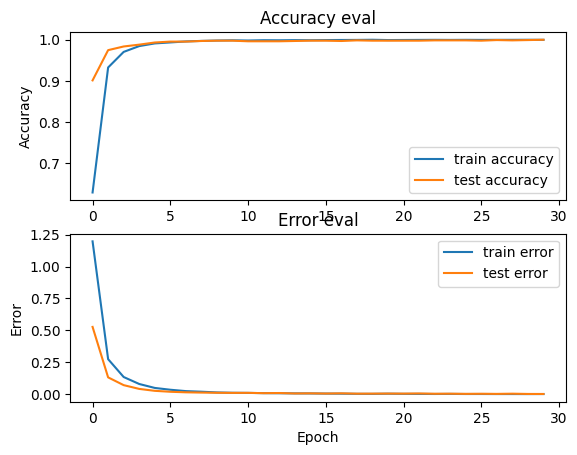

71/71 - 0s - loss: 0.0055 - accuracy: 0.9991 - 437ms/epoch - 6ms/step

Test accuracy: 0.9991111159324646
1/1 [==============================] - 0s 119ms/step
Target: 2, Predicted label: 2
Service Type: fire


In [ ]:
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)



    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]


    # predict sample
    predict(model, X_to_predict, y_to_predict)

In [ ]:
print(X_to_predict)
print("\n__________________________________________________________________\n")
print(y_to_predict)

[[[-7.79336975e+02]
  [ 7.37430038e+01]
  [ 3.20888481e+01]
  [ 2.30525227e+01]
  [ 1.32523432e+01]
  [ 1.46623793e+01]
  [ 1.05584669e+01]
  [ 1.29378853e+01]
  [ 8.01905727e+00]
  [ 1.12996311e+01]
  [ 6.85684872e+00]
  [ 4.40842295e+00]
  [ 1.31086540e+00]]

 [[-7.68427795e+02]
  [ 5.76485977e+01]
  [ 3.30519066e+01]
  [ 2.47913780e+01]
  [ 1.82137909e+01]
  [ 1.96519394e+01]
  [ 7.36121464e+00]
  [ 1.08279686e+01]
  [ 1.09008408e+01]
  [ 1.13382626e+01]
  [ 8.45578575e+00]
  [ 7.57618618e+00]
  [ 1.60435164e+00]]

 [[-7.75770935e+02]
  [ 4.73528214e+01]
  [ 2.87044907e+01]
  [ 2.80346718e+01]
  [ 2.36044254e+01]
  [ 2.31252975e+01]
  [ 9.04664993e+00]
  [ 1.25958252e+01]
  [ 1.17214813e+01]
  [ 1.36279497e+01]
  [ 1.00374870e+01]
  [ 8.06544304e+00]
  [ 3.79737616e+00]]

 [[-6.56201477e+02]
  [ 2.14105606e+01]
  [ 2.77232552e+01]
  [ 3.22154961e+01]
  [-1.09048395e+01]
  [ 1.45858345e+01]
  [ 1.25719061e+01]
  [-1.18979988e+01]
  [ 6.93812847e+00]
  [ 1.06548100e+01]
  [ 3.70306635